# *Monod* demonstration: distinguishing bursty and constitutive models of transcriptional variation

We ran the *Monod* inference pipeline on thirteen datasets: pre-clustered mouse brain cell data, disaggregated into GABAergic and glutamatergic cell types, and five 10X Genomics mouse tissue samples. Each dataset was fit using the bursty and constitutive models for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given maximum likelihood estimates under each model, we can apply the standard Akaike Information Criterion framework to attempt to assign probabilities to the models. These estimates are necessarily incomplete, as they do not take into account the parameter uncertainties; further, they appear to overestimate confidence in model selections. However, this is an essential first step toward exploring model ensembles. 

We find that the Poissonian constitutive model is overwhelmingly less probable than the overdispersed bursty model.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [3]:
models = ('Bursty','Constitutive')

In [4]:
n_models = len(models)

In [5]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dn1 = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 

dir_string1 = './fits/gg_220527_021_allen_celltypes_1'

result_strings_bursty = [dir_string1+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results.res' for x in dn1]
result_strings_constitutive = [dir_string1+'/'+x+'/Constitutive_Poisson_20x21/grid_scan_results.res' for x in dn1]
n_datasets = len(result_strings_bursty)

dn2 =  ['heart_1k','heart_10k','neuron_1k','neuron_10k','brain_5k']
dn2 = [x+'_v3' for x in dn2]
dataset_names = dn1 + dn2

dir_string2 = './fits/gg_220526_021_modelcomp_1'
result_strings_bursty += [dir_string2+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dn2]
result_strings_constitutive += [dir_string2+'/'+x+'/Constitutive_Poisson_20x21/grid_scan_results.res' for x in dn2]

sd_strings = [dir_string1+'/'+x+'/raw.sd' for x in dn1] + [dir_string2+'/'+x+'/raw.sd' for x in dn2]


In [7]:
n_datasets = len(sd_strings)

## AIC weight computation

Now, we iterate over the results for the two models, identify the parameter optima, and compute Akaike weights according to the procedure in Burnham and Anderson (2002).

INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Constitutive_Poisson_20x21/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/AIC_comparison_allen_A08_gaba_burst_const.png.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/raw.sd.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Constitutive_Poisson_20x21/grid_scan_results.res.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/AIC_comparison_allen_A08_glu_burst

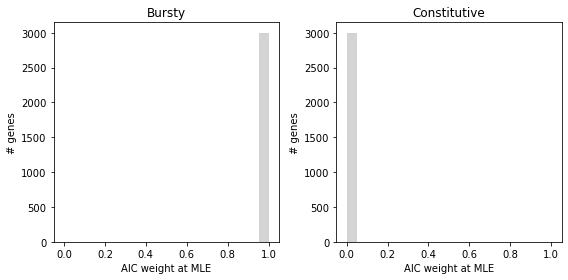

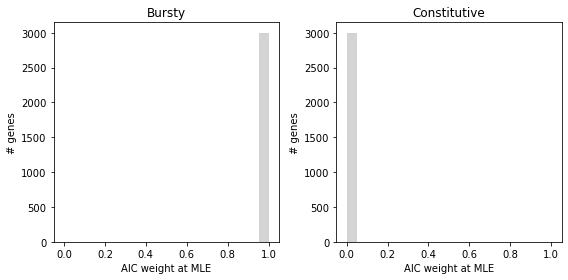

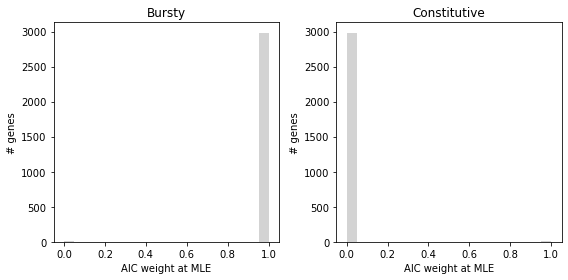

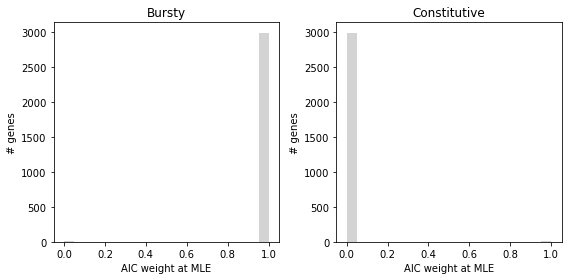

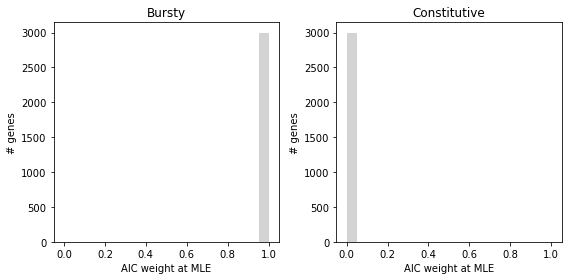

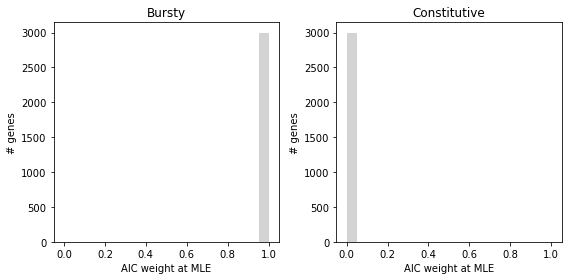

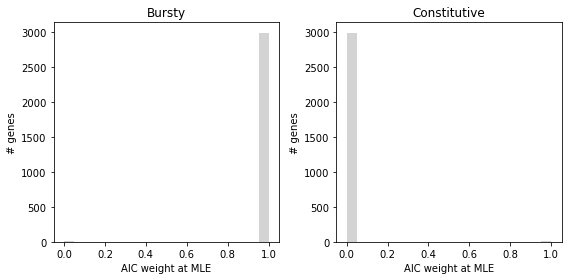

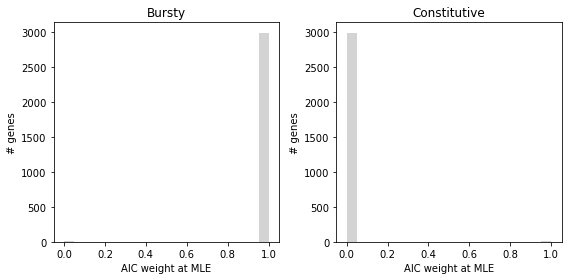

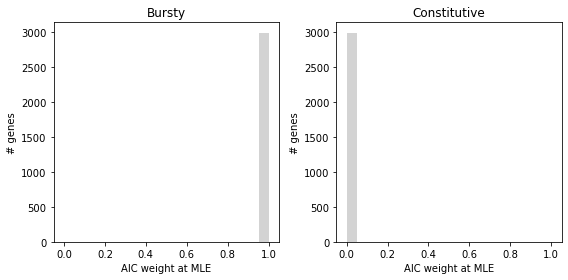

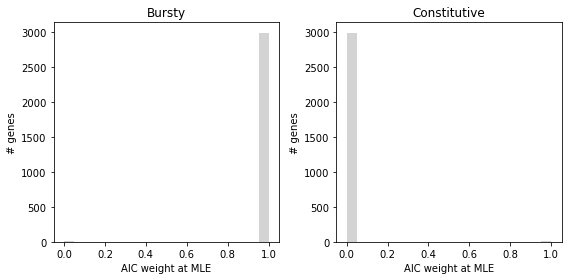

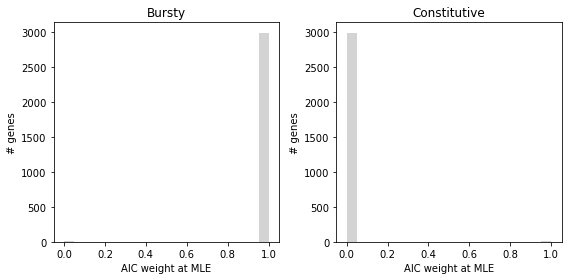

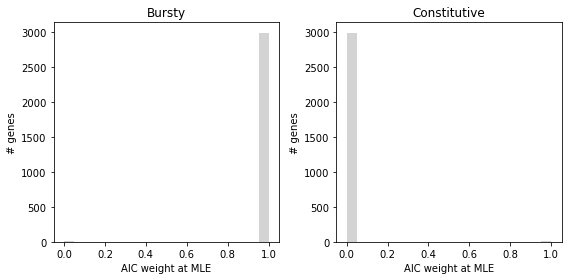

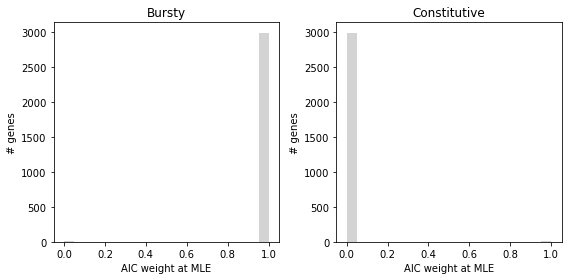

In [10]:
sr_arr = []
w = []

for j in range(n_datasets):
    sd = load_search_data(sd_strings[j])
    
    sr_burst = load_search_results(result_strings_bursty[j])
    sr_burst.find_sampling_optimum()
    
    sr_const = load_search_results(result_strings_constitutive[j])
    sr_const.find_sampling_optimum()
    if j<len(dn1):
        make_batch_analysis_dir([sr_burst,sr_const],dir_string1)
    else:
        make_batch_analysis_dir([sr_burst,sr_const],dir_string2)

    w_ = plot_AIC_weights([sr_burst,sr_const],sd,models,meta=dataset_names[j]+'_burst_const',savefig=True)
    w.append(w_)

In [11]:
w = np.asarray(w)

In [12]:
w.mean(2).min(0)

array([9.95562125e-01, 3.39619751e-04])

In [13]:
w.mean(2).max(0)

array([0.99966038, 0.00443787])

In [14]:
(w[:,1,:]>0.5).sum(1)

array([ 1,  2, 13,  5,  2,  3, 11,  6,  2,  6,  9, 10,  9])

We find that the constitutive model is extremely rarely selected (up to 13/3000 genes in a single dataset).

In [15]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 97 seconds.
